# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from setup import *

In [3]:
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
import osmnx
import shapely
import yaml

# Regional boundaries

## Define regions

**[Austin MSA](https://en.wikipedia.org/wiki/Greater_Austin#Boundaries)**

In [4]:
austin = Region('Austin', 'Texas', [
    'Bastrop','Caldwell','Hays','Travis','Williamson'])

**[Baton Rouge MSA](https://en.wikipedia.org/wiki/Baton_Rouge_metropolitan_area#Parishes)**

In [5]:
baton_rouge = Region('Baton Rouge', 'Louisiana', [
    'Ascension', 'East Baton Rouge', 'East Feliciana', 'Iberville', 'Livingston',
    'Pointe Coupee', 'St. Helena', 'West Baton Rouge', 'West Feliciana'])

**[Houston MSA](https://en.wikipedia.org/wiki/Greater_Houston#Counties)**

In [6]:
houston = Region('Houston', 'Texas', [
    'Austin','Brazoria','Chambers','Fort Bend','Galveston',
    'Harris','Liberty','Montgomery','Waller'])

**[Indianapolis MSA](https://en.wikipedia.org/wiki/Indianapolis_metropolitan_area#Counties)**

In [7]:
indy = Region('Indianapolis', 'Indiana', [
    'Boone','Brown','Hamilton','Hancock','Hendricks','Johnson',
    'Madison','Marion','Morgan','Putnam','Shelby'])

**[San Antonio MSA](https://en.wikipedia.org/wiki/Greater_San_Antonio#Counties)**

In [8]:
san_antonio = Region('San Antonio', 'Texas', [
    'Atascosa', 'Bandera', 'Bexar', 'Comal', 
    'Guadalupe', 'Kendall', 'Medina', 'Wilson'])

In [9]:
regions = [austin, baton_rouge, houston, indy, san_antonio]
# regions = [baton_rouge, indy, austin, houston]

## City limit

In [10]:
def get_city_limit(rgn, save=True, overwrite=False):
    outfile = rgn.data / 'city_limit.gpkg'
    if outfile.exists() and not overwrite:
        return gpd.read_file(outfile)
    df = osmnx.geocode_to_gdf(rgn.geocode)
    df = df[['geometry']].to_crs(CRS_DEG)
    if save:
        df.to_file(U.mkfile(outfile))
    return df

In [11]:
# t=0:09
for rgn in regions:
    get_city_limit(rgn)

## Counties layer

### US counties

In [12]:
def get_us_counties(save=True, overwrite=False):
    outfile = P.root / 'regions/_etc/us_counties.shp.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    zipfile = P.root / 'regions/_etc/us_counties.shp.zip'
    df = mk.geo.get_tiger_shp('county', U.mkfile(zipfile))
    df = df.rename(columns=str.lower).to_crs(CRS_DEG)
    df = df[['statefp', 'countyfp', 'geoid', 'name', 
             'aland', 'awater', 'geometry']]
    if save:
        df.to_parquet(U.mkfile(outfile))
        zipfile.unlink()
    return df
    
us_counties = get_us_counties().set_crs(CRS_DEG).disp() # t=0:14

3,234 rows x 7 cols; Memory: 0.8 MiB; CRS: EPSG:4326


statefp  countyfp     geoid      name       aland    awater  \
   <object>  <object>  <object>  <object>     <int64>   <int64>   
0        31       039     31039    Cuming  1477645345  10690204   

                                            geometry  
                                          <geometry>  
0  POLYGON ((-96.555155 41.915868, -96.555153 41....

### Get counties and bounding boxes

In [13]:
def get_counties(rgn, us_counties=us_counties, 
                 state_fips=mk.geo.US_STATES_FIPS,
                 save=True, overwrite=False):
    outfile = rgn.data / 'counties.gpkg'
    if outfile.exists() and not overwrite:
        return gpd.read_file(outfile)
    fips = state_fips[rgn.state.upper()]
    df = us_counties.query(f'statefp == "{fips:02}"')
    df = df[df['name'].isin(rgn.counties)].drop(columns='statefp')
    df = df.set_index('geoid').sort_index().reset_index()
    if save:
        df.to_file(outfile)
    return df

In [14]:
for rgn in regions:
    rgn.cnty = get_counties(rgn)
    rgn.bbox = rgn.cnty.geometry.unary_union.bounds
    P.params.set({'regions': {rgn.key: {'bbox': list(rgn.bbox)}}})

## Block groups layer

In [15]:
def get_cbgs(rgn, state_fips=mk.geo.US_STATES_FIPS,
             save=True, overwrite=False):
    outfile = rgn.data / 'cbgs.gpkg'
    if outfile.exists() and not overwrite:
        return gpd.read_file(outfile)
    fips = state_fips[rgn.state.upper()]
    zipfile = rgn.data / 'state_cbgs.shp.zip'
    df = mk.geo.get_tiger_shp('bg', zipfile, fips=fips)
    df = df.rename(columns=str.lower)
    df = df.merge(rgn.cnty.rename(columns={'name': 'county'})
                  [['countyfp', 'county']], on='countyfp')
    df = df[['geoid','county','aland','awater','geometry']]
    df = df.reset_index(drop=True).to_crs(CRS_DEG)
    if save:
        df.to_file(U.mkfile(outfile))
        zipfile.unlink()
    return df

In [16]:
# t=0:31 (downloading) (austin=>0:08, baton_rouge=>0:10, houston=>0:10, indy=>0:03, san_antonio=>0:08)
for rgn in tqdm(regions):
    rgn.cbgs = get_cbgs(rgn)

  0%|          | 0/5 [00:00<?, ?it/s]

# Census data

## Download data

In [17]:
def get_acs(rgn, state_fips=mk.geo.US_STATES_FIPS,
            cols=mk.acs.IMP_FIELDS, save=True, overwrite=False):
    outfile = rgn.data / 'acs.gpkg'
    if outfile.exists() and not overwrite:
        return gpd.read_file(outfile)
    df = mk.acs.download([
        ('state', f'{state_fips[rgn.state.upper()]:02}'),
        ('county', ','.join(rgn.cnty['countyfp'])),
        ('tract', '*'), ('block group', '*')
    ], list(cols.keys()))
    x = Pdf([dict(zip(df.index.names, x)) for x in df.index])
    df.index = x['state'] + x['county'] + x['tract'] + x['block group']
    df = df.rename_axis('geoid').rename(columns=cols)
    df = rgn.cbgs.reset_index().merge(df.reset_index(), on='geoid')
    df = df.drop(columns='index', errors='ignore')
    df['pop_density'] = df['popu'] / (df['aland'] * U.SQM2SQMI)
    if save:
        df.to_file(U.mkfile(outfile))
    return df

In [18]:
# t=0:27 (downloading)
for rgn in tqdm(regions):
    rgn.acs = get_acs(rgn, overwrite=False)

  0%|          | 0/5 [00:00<?, ?it/s]

## Visualize

### General template

In [19]:
def plot_rgn_acs(rgn, var, title, vmax=None, df=None, 
                 cmap='magma_r', size=(8, 8), dpi=100, save=True):
    ax = U.plot(size=size, dpi=dpi, axoff=True)
    ax.set_title(f'{title}\n({rgn.name} MSA)', fontsize=16)
    df = df.to_crs(CRS_DEG) if df is not None else rgn.acs
    df.plot(ax=ax, column=var, cmap=cmap, vmax=vmax,
            linewidth=0.2, edgecolor='k', legend=True,
            legend_kwds=dict(shrink=0.6, label=title))
    rgn.cnty.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)
    if save:
        P.imsave(f'{rgn.name} - {title}', root=P.fig / 'ACS')

### Indianapolis

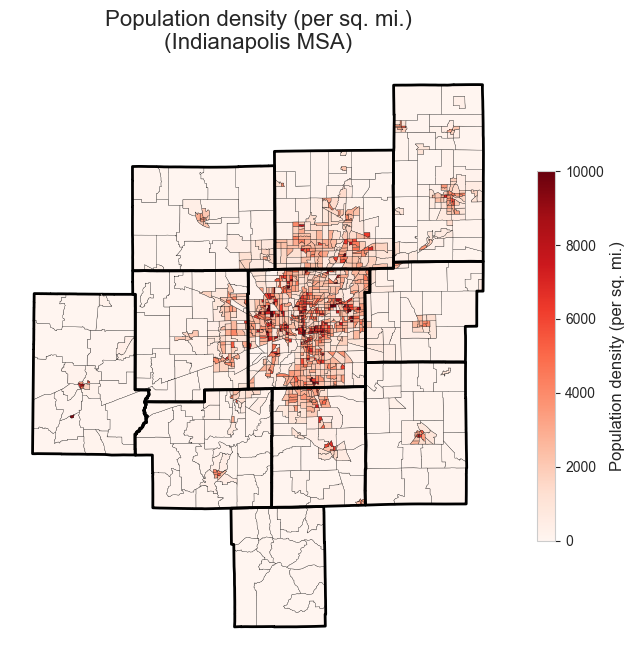

In [20]:
plot_rgn_acs(indy, 'pop_density', 'Population density (per sq. mi.)', 10_000, cmap='Reds')

### Houston

### Austin

# Land use

## Download data
The data of the study regions' land use layers were downloaded manually from the associated links (mostly city data portals). These were downloaded as `.shp.zip` files or something similar in the file format: `{region.data}/landuse/raw.{extension}`.

The land use category codes were intuitively categorized as either residential or non-residential and stored in a separate file: `{P.data}/_etc/landuse_codes.yaml`.

In [22]:
with open(P.root / 'regions/_etc/landuse_codes.yaml', 'rb') as f:
    lu_codes = yaml.safe_load(f)

**AUSTIN** (https://data.austintexas.gov/Locations-and-Maps/Land-Use-Inventory-Detailed/fj9m-h5qy)

Land use categories on https://data.austintexas.gov/api/assets/D02A50E8-717D-4715-B4D3-4A6AD3BD50C2.

**BATON ROUGE** (https://data.brla.gov/Housing-and-Development/Existing-Land-Use/u7dr-94zn)

* Land use codes in the legend of the dashboard on https://gismaps.brla.gov/maps/existing-land-use-1.
* Tax parcel data also available on https://gisdata.brla.gov/datasets/73dc8f3b384e4dfcbeb162996fef62d0 but land use codes not present.

**HOUSTON** (https://cohgis-mycity.opendata.arcgis.com/datasets/coh-land-use)

**INDIANAPOLIS** (https://data.indy.gov/datasets/IndyGIS::current-land-use)

**SAN ANTONIO**: (https://opendata-cosagis.opendata.arcgis.com/datasets/CoSAGIS::cosa-zoning)

## Combined resi/non-residential area

In [23]:
def get_resi_nonresi(rgn, overwrite=False):
    outfile = rgn.data / 'landuse/resi_nonresi.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    df = gpd.read_parquet(rgn.data / 'landuse/full.parquet')
    df = df[['residential','geometry']].dissolve('residential')
    df.reset_index().to_parquet(U.mkfile(outfile))
    return df

# %time x = get_resi_nonresi(baton_rouge, overwrite=True)

In [24]:
# t=5:38 ({austin=>0:26, baton_rouge=>0:07, houston=>3:03, indy=>0:32, san_antonio=>1:36})
for rgn in regions:
    rgn.resi_nonresi = get_resi_nonresi(rgn)

### Visualize

CPU times: user 6.44 s, sys: 636 ms, total: 7.08 s
Wall time: 6.54 s


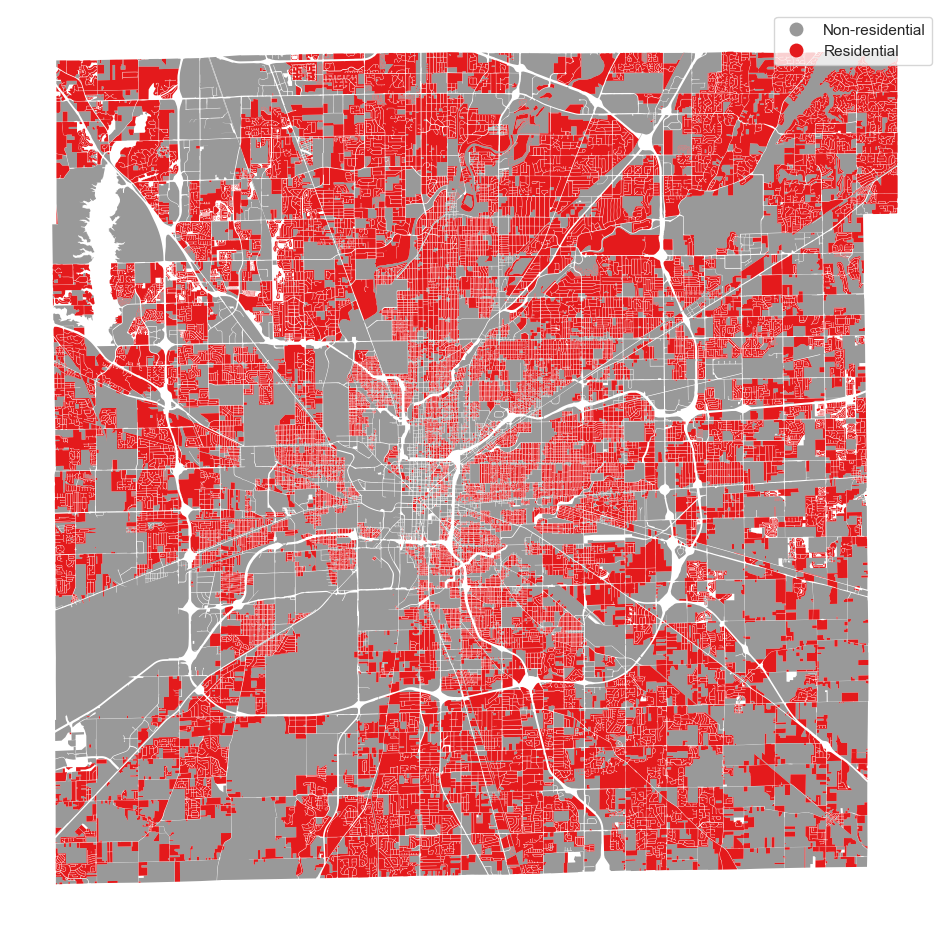

In [25]:
def plot_resi_nonresi(rgn, size=(12, 12), dpi=100, show=True, save=True):
    lu = get_resi_nonresi(rgn)
    lu['kind'] = lu['residential'].map({True: 'Residential', False: 'Non-residential'})
    ax = U.plot(size=size, dpi=dpi, axoff=1)
    lu.plot(ax=ax, column='kind', cmap='Set1_r', legend=True, edgecolor='none')
    if save: P.imsave(f'Land use map – {rgn.name}')
    if not show: plt.close()
    
%time x = plot_resi_nonresi(indy); x # t=0:07

Save the figures for all regions:

## Overall boundary

In [26]:
def get_lu_boundary(rgn, save=True, overwrite=False):
    outfile = rgn.data / 'landuse/lu_boundary.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    df = gpd.read_parquet(rgn.data / 'landuse/resi_nonresi.parquet')
    df = df.dissolve().set_crs(CRS_DEG)
    df = df.drop(columns='residential', errors='ignore')
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

In [27]:
# t=2:59 ({austin=>0:12, baton_rouge=>0:06, houston=>1:52, indy=>0:15, san_antonio=>0:24})
for rgn in regions:
    rgn.lu_boundary = get_lu_boundary(rgn)

## Residential area buffers

In [28]:
# buffer widths (meters) for M1 (residential detection rate)
resi_buffers = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400]

### Original

In [29]:
def get_resi_buffers(rgn, buffers=resi_buffers, save=True, overwrite=False):
    print(rgn.name)
    fpath = lambda buf: rgn.data / f'landuse/resi_buffers/{buf}.parquet'
    res = []
    for buf in buffers:
        if fpath(buf).exists() and not overwrite:
            df = gpd.read_parquet(fpath(buf))
            res.append(df)
    if len(res) > 0:
        return pd.concat(res)
    start_time = dt.datetime.now()
    df = gpd.read_parquet(rgn.data / 'landuse/resi_nonresi.parquet')
    r0 = (df.query('residential').assign(buffer=0)
          [['buffer', 'geometry']].to_crs(CRS_M))
    if save and not fpath(0).exists():
        r0.to_crs(CRS_DEG).to_parquet(fpath(0))
    for buf in tqdm(buffers):
        x = r0.buffer(buf).to_crs(CRS_DEG).iloc[0]
        df = Gdf({'buffer': buf, 'geometry': [x]}, crs=CRS_DEG)
        if save:
            df.to_parquet(fpath.format(buf))
        res.append(df)
    res = pd.concat(res)
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return res

### Within residential area

In [30]:
def get_resi_buffers_clipped(rgn, buffers=resi_buffers, save=True, overwrite=False):
    root = rgn.data / f'landuse'
    fpath = lambda buf: root / f'resi_buffers_clipped/{buf}.parquet'
    buffers = [0] + list(buffers)
    res = []
    for buf in buffers:
        if fpath(buf).exists() and not overwrite:
            df = gpd.read_parquet(fpath(buf))
            res.append(df)
    if len(res) > 0:
        return pd.concat(res).to_crs(CRS_DEG)
    print('Processing', rgn.name)
    start_time = dt.datetime.now()
    lu = rgn.lu_boundary().to_crs(CRS_DEG)
    for buf in tqdm(buffers):
        orig = gpd.read_parquet(root / f'resi_buffers/{buf}.parquet')
        clipped = orig.clip(lu)
        geom = clipped.iloc[0].geometry
        if isinstance(geom, shapely.geometryCollection):
            geom = shapely.MultiPolygon([
                x for x in geom.datas if isinstance(x, shapely.Polygon)])
            clipped = Gdf({'buffer': [buf], 'geometry': [geom]}, crs=CRS_DEG)
        if save:
            clipped.to_parquet(U.mkfile(fpath(buf)))
        res.append(clipped)
    res = pd.concat(res).to_crs(CRS_DEG)
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return res

### Visualize the buffers

CPU times: user 22.5 s, sys: 1.71 s, total: 24.2 s
Wall time: 24.5 s


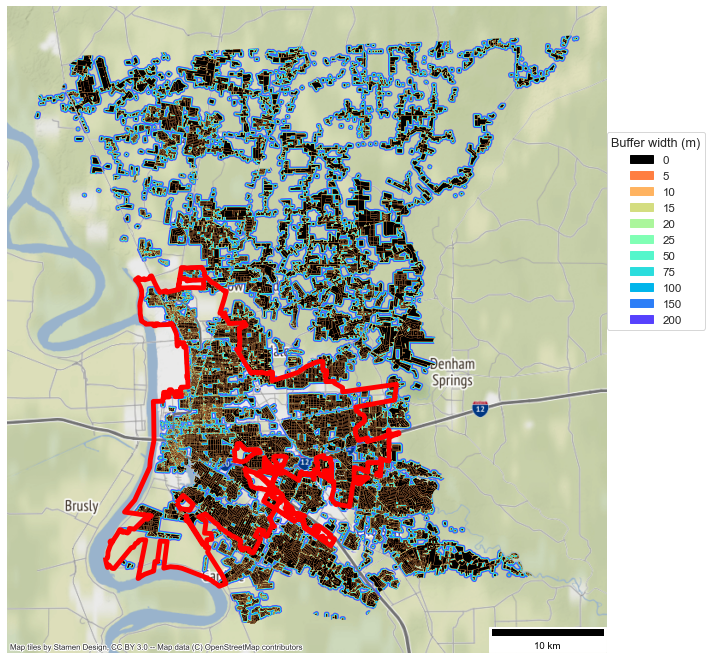

In [31]:
def plot_resi_buffers(rgn, buffers=resi_buffers, clipped=True, cmap='rainbow', 
                      size=(12, 12), dpi=70, legend_loc=(1., .5), bg_map=True, show=True):
    city_lim = gpd.read_file(rgn.data / 'city_limit.gpkg').to_crs(CRS_M)
    func = get_resi_buffers_clipped if clipped else get_resi_buffers
    df = func(rgn, buffers).to_crs(CRS_M)
    df = df.set_index('buffer').sort_index(ascending=False)
    df['color'] = list(sns.color_palette(cmap, len(df)).as_hex())
    df.loc[0, 'color'] = 'k'
    ax = U.plot(size=size, dpi=dpi, axoff=1)
    df.plot(ax=ax, color=df['color'], edgecolor='none')
    ax.legend(handles=[mpl.patches.Patch(color=color, label=str(buf)) 
                        for buf, color in df.sort_index()['color'].to_dict().items()],
              title='Buffer width (m)', loc=legend_loc, fontsize=12)
    city_lim.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=5)
    if bg_map:
        ctx.add_basemap(ax=ax, crs=CRS_M, alpha=1)
    ax.add_artist(ScaleBar(1, location='lower right'))
    P.imsave('Land use buffers in ' + rgn.name)
    if not show: plt.close()

%time x = plot_resi_buffers(baton_rouge, resi_buffers[:-4]); x # t=0:28

## Fig: Study regions

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 32.5 s, sys: 1.89 s, total: 34.3 s
Wall time: 38.5 s


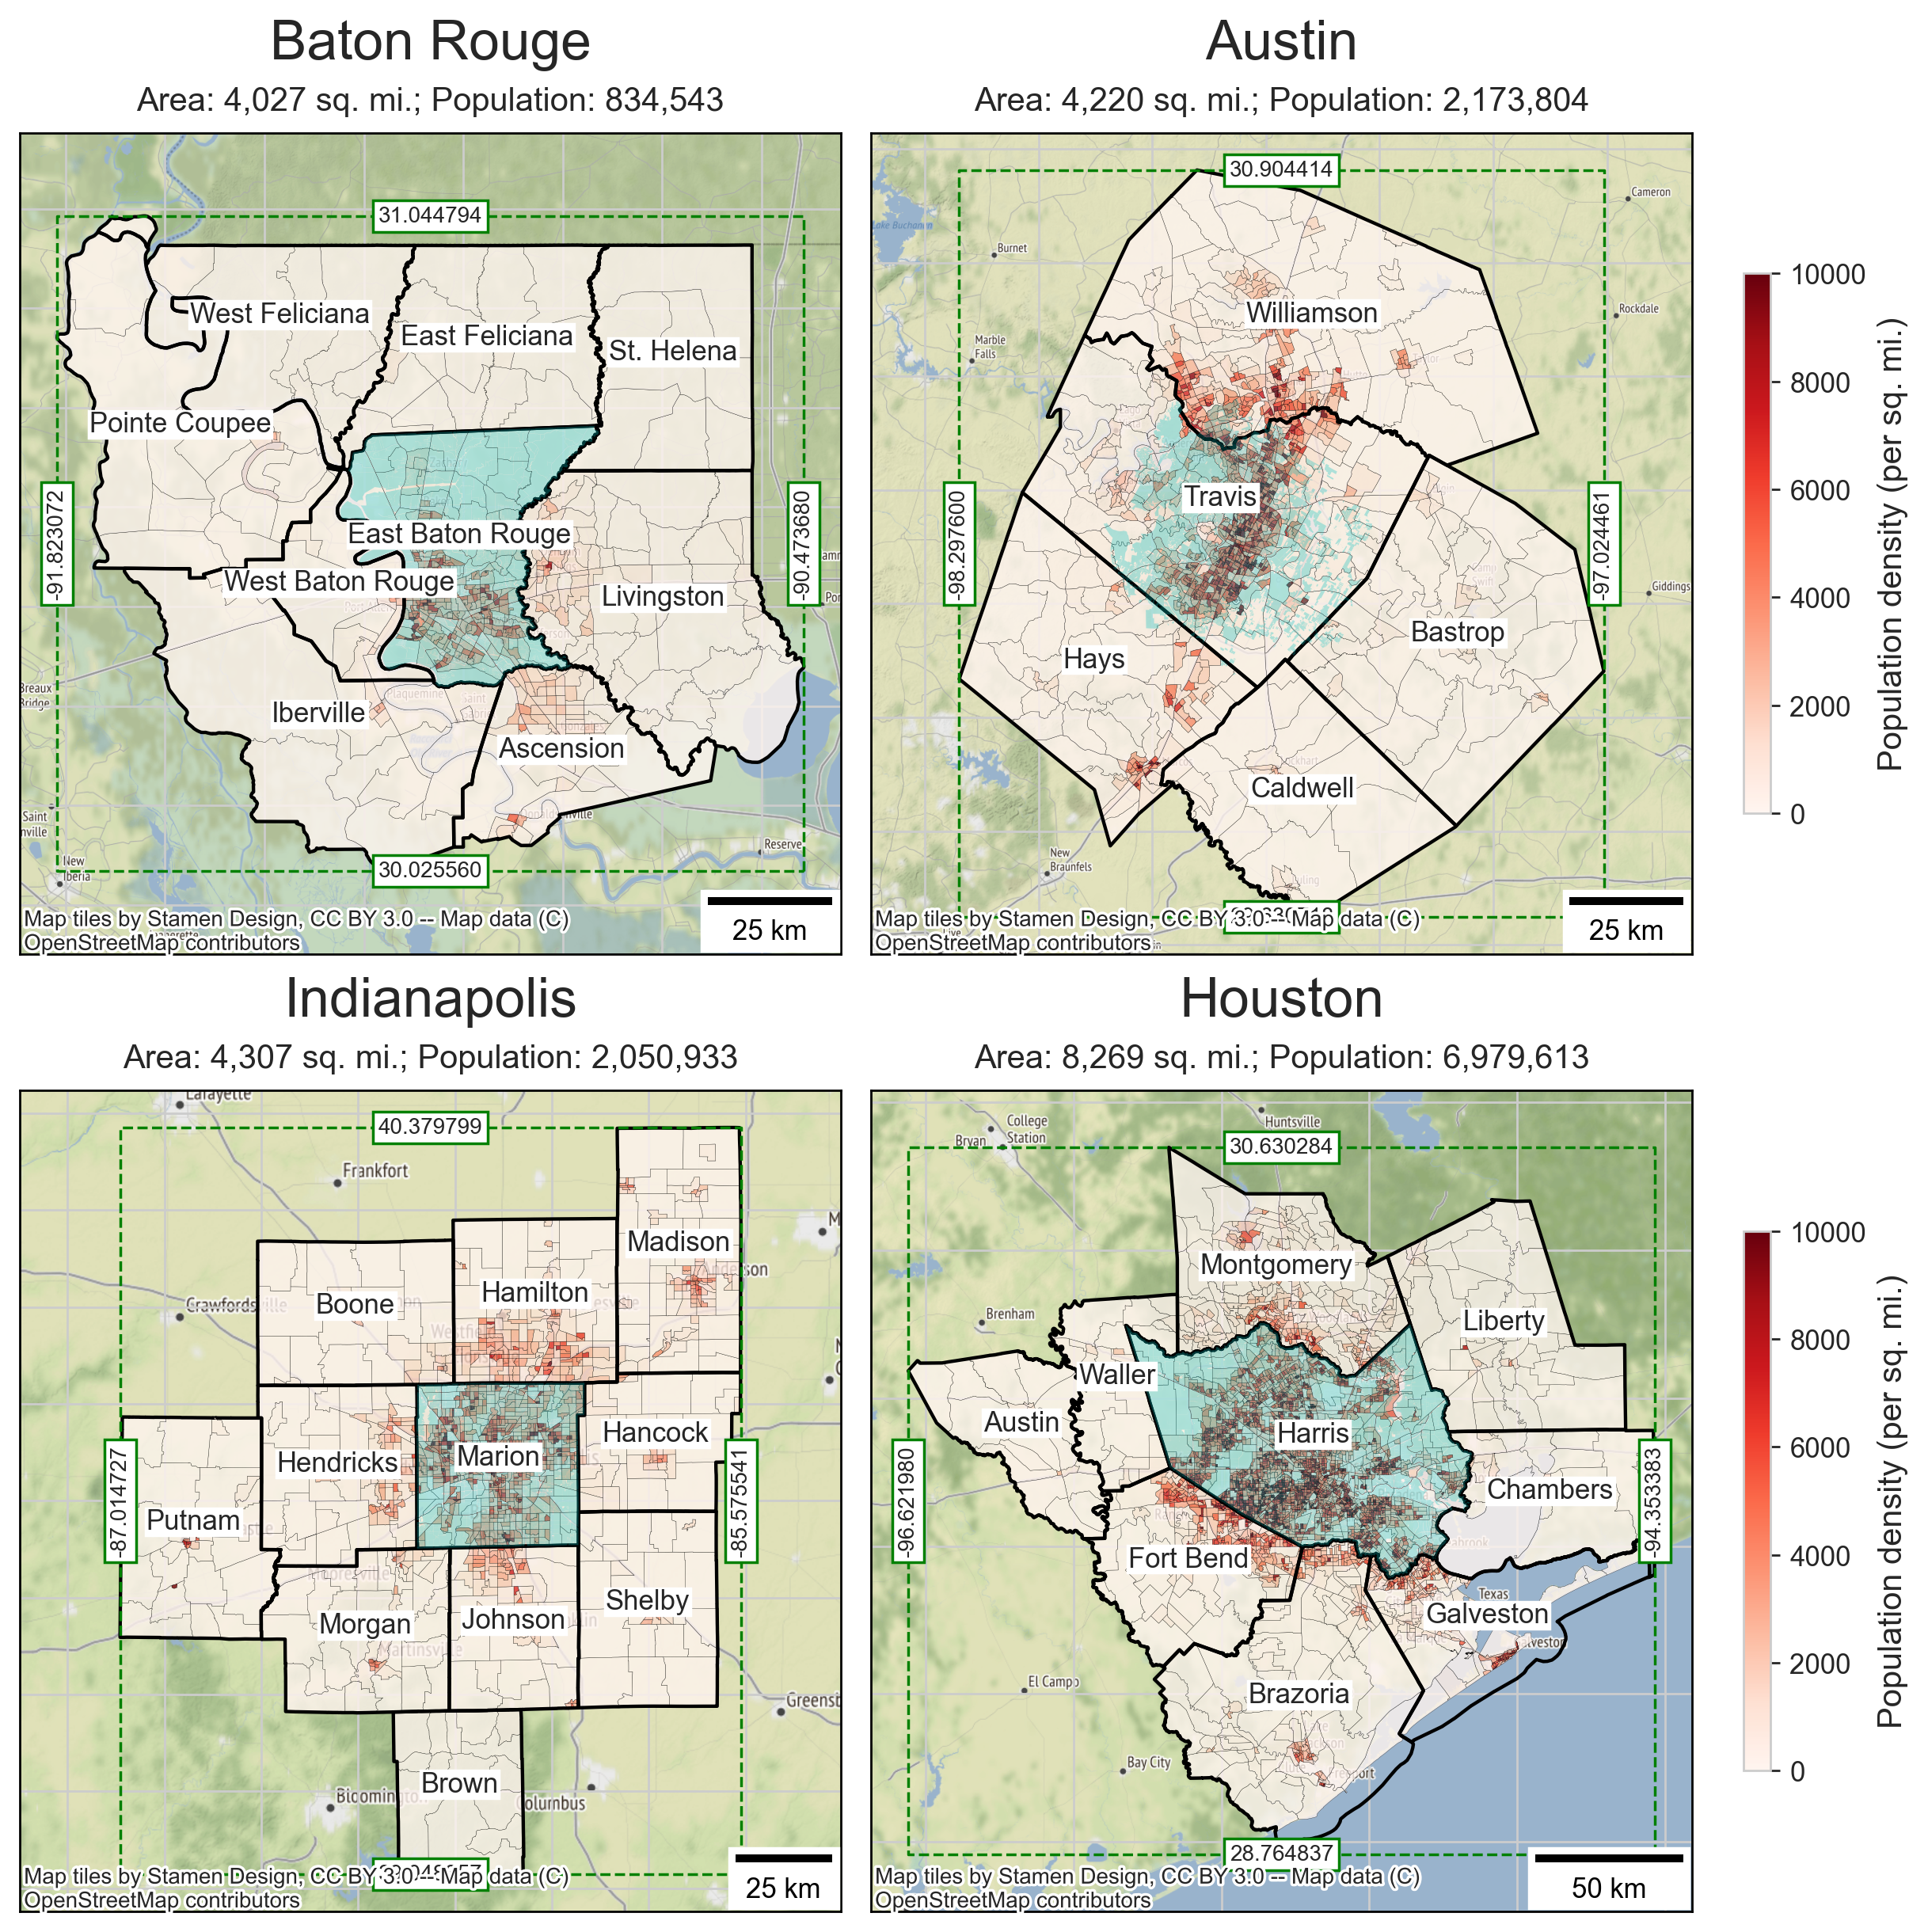

In [32]:
def fig_study_regions(regions, width_ratios=[1, 1], max_density=10000,
                      size=(5, 5), dpi=100):
    ncol = len(width_ratios)
    nrow = int(np.ceil(len(regions) / ncol))
    fig = plt.figure(figsize=(ncol * size[0], nrow * size[1]), dpi=dpi)
    gs = mpl.gridspec.GridSpec(nrow, ncol, width_ratios=width_ratios)
    for i, j in tqdm(list(it.product(range(nrow), range(ncol)))):
        k = i * ncol + j
        if k >= len(regions): continue
        rgn = regions[k]
        ax = plt.subplot(gs[i, j])
        acs = rgn.acs.to_crs(CRS_M)
        acs.plot(ax=ax, column='pop_density', cmap='Reds', vmax=max_density,
                 linewidth=0.1, edgecolor='k', legend=j == ncol - 1, alpha=0.8,
                 legend_kwds=dict(shrink=0.6, label='Population density (per sq. mi.)'))
        cnty = rgn.cnty.to_crs(CRS_M)
        cnty.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=1.25)
        bbox = Gdf({'geometry': [shapely.box(*rgn.bbox)]}, crs=CRS_DEG).to_crs(CRS_M)
        bbox.plot(ax=ax, facecolor='none', edgecolor='g', linestyle='--')
        minx, miny, maxx, maxy = bbox.bounds.iloc[0]
        minLon, minLat, maxLon, maxLat = bbox.to_crs(CRS_DEG).bounds.iloc[0]
        cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
        for val, x, y, angle in [(maxLat, cx, maxy, 0), (maxLon, maxx, cy, 90),
                                 (minLat, cx, miny, 0), (minLon, minx, cy, 90)]:
            ax.text(x, y, f'{val:.6f}', rotation=angle,
                    fontsize=8, ha='center', va='center', 
                    bbox=dict(pad=2, edgecolor='g', facecolor='w'))
        lu_boundary = gpd.read_parquet(rgn.data / 'landuse/lu_boundary.parquet')
        lu_boundary.to_crs(CRS_M).plot(ax=ax, facecolor='c', edgecolor='none', alpha=0.3)
        cnty_labels = (cnty.assign(geometry = lambda df: df.geometry.centroid)
                       .set_index('name').geometry.apply(lambda x: x.coords[0]))
        for name, xy in cnty_labels.to_dict().items():
            ax.text(*xy, name, ha='center', bbox=dict(fc='w', pad=0.2))
        popu = acs['popu']
        ax.add_artist(ScaleBar(1, location='lower right'))
        ax = U.plot(ax, framebordercolor='k')
        ax.set_title(rgn.name, fontsize=20, y=1.07)
        area = 'Area: {:,.0f} sq. mi.'.format(rgn.cnty['aland'].sum() * U.SQM2SQMI)
        popu = 'Population: {:,.0f}'.format(acs['popu'].sum())
        ax.text(0.5, 1.02, f'{area}; {popu}', ha='center', va='bottom',
                transform=ax.transAxes, fontsize=12)
        ax.set_xticklabels([]); ax.set_yticklabels([])
        w, h = (maxx - minx) / 2, (maxy - miny) / 2
        side = 1.1 * max(w, h)
        ax.set_xlim(cx - side, cx + side); ax.set_ylim(cy - side, cy + side)
        ctx.add_basemap(ax=ax, crs=CRS_M, zorder=-1)
    plt.tight_layout()

fig_rgns = [baton_rouge, austin, indy, houston]
%time x = fig_study_regions(fig_rgns, [1, 1.25], dpi=250); x # t=0:42